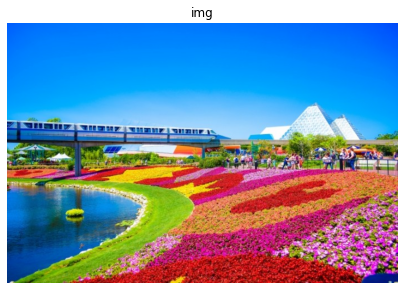

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from skimage.transform import rescale, resize, downscale_local_mean

img = cv2.imread("pic.jpg")
def draw_picture(image, title, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.title(title)
    plt.show()
draw_picture(img, "img")

164131


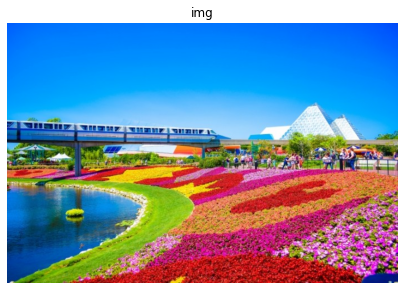

In [2]:
# складываем в одномерный массв троек
i_r = img.copy().reshape((700*466, 3))
# Исходное число цветов
_ = pd.DataFrame(i_r,dtype=np.short)
_.drop_duplicates(inplace = True, ignore_index=True)
print(len(_))
# восстанавливаем в рисунок
draw_picture(i_r.reshape((466,700, 3)), "img")

In [114]:
data = img.copy()
fraction = 50
epsilon=10
min_samples=5
# image = data
image = (resize(data, 
    (int(data.shape[0] / fraction), 
    int(data.shape[1] / fraction)),
    anti_aliasing=False)*255).astype(int)
a = DBSCAN(eps=epsilon, min_samples=min_samples).fit(image.reshape((image.shape[0]*image.shape[1], 3)))
print("число кластеров %d" % len(np.unique(a.labels_)))
print("число 'шумовых' %d" % len(a.labels_[np.where(a.labels_ == -1)]))
print("число всего %d" % len(a.labels_))

число кластеров 81
число 'шумовых' 1466
число всего 13020


[ 76 132  90]


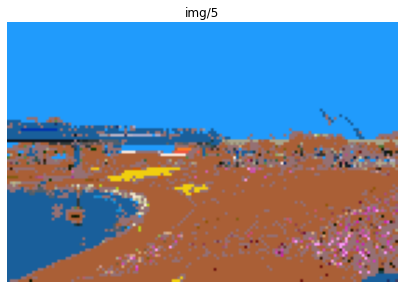

In [124]:
fl = image.copy().reshape((image.shape[0]*image.shape[1], 3))
for l in np.unique(a.labels_):
    mean = np.mean(fl[np.where(a.labels_ == l)], axis=(0,)).astype(int)
    fl[np.where(a.labels_ == l)] = mean
draw_picture(fl.reshape((image.shape[0],image.shape[1], 3)), "img/%d" % (fraction))

In [19]:
setup = [
# {
#     'alg':'KMeans',    'n_clusters':2,},
# {
#     'alg':'KMeans',    'n_clusters':5,},
# {
#     'alg':'KMeans',    'n_clusters':10,},
# {
#     'alg':'KMeans',    'n_clusters':20,},
{
    # не работает на больших эпсилон, т.к. считает матрицу расстояний (кривая реализация в scikit-learn) и падает по памяти
    'alg':'DBSCAN',    'eps':1,   'min_samples':100}, 
# {
#     'alg':'AgglomerativeClustering',    'n_clusters':2,},
# {
#     'alg':'AgglomerativeClustering',    'n_clusters':5,},
# {
#     'alg':'AgglomerativeClustering',    'n_clusters':10,},
# {
#     'alg':'AgglomerativeClustering',    'n_clusters':20,},
]

In [21]:
def run(stp,data):
    res = stp.copy()
    for i,d in enumerate(stp):
        # cluster
        # print('alg: %s' % (d['alg']))
        if d['alg']=='KMeans':
            kmeans = KMeans(n_clusters=d['n_clusters'], random_state=0).fit(data)
            res[i]['num_clusters'] = d['n_clusters']
        if d['alg']=='DBSCAN':
            db = DBSCAN(eps=d['eps'], min_samples=d['min_samples']).fit(data)
            df_dbscan = pd.DataFrame(data[db.core_sample_indices_])
            # число кластеров
            # print(len(df_dbscan.drop_duplicates()))
            # число "шумовых"
            # print(len(db.labels_[np.where(db.labels_ == -1)]))
            res[i]['num_clusters'] = len(df_dbscan.drop_duplicates())
            res[i]['fitted'] = db
            break
        if d['alg']=='AgglomerativeClustering':
            agl = AgglomerativeClustering(linkage="single", n_clusters=d['n_clusters']).fit(data)
            res[i]['num_clusters'] = agl.n_clusters_
        # img_f = img_as_float(data.copy())
        # складываем в одномерный массв троек
        a = data.copy()
        # kmeans = KMeans(n_clusters=5, random_state=0).fit(i_r)
        # len(kmeans.cluster_centers_)
        df = pd.DataFrame(data.copy())
        # a = i_r
        # print(kmeans.cluster_centers_)
        
        # calc SSIM
        for idx, cntr in enumerate(kmeans.cluster_centers_): 
            # a0 = cntr
            cntr_idx = np.sum(np.square(np.abs(a-cntr)),1).argmin()
            cntr_color = a[cntr_idx]
            # print('cntr = %s' % (str(cntr)))
            # print('cntr_idx = %s' % (str(cntr_idx)))
            # print('color = %s' % (str(cntr_color)))
            df.loc[kmeans.labels_== idx, :] = cntr_color
            # print(len(df.loc[kmeans.labels_== idx, :]))
        res[i]['ssim'] = ssim(a.reshape((466,700, 3)), df.to_numpy().reshape((466,700, 3)), data_range=a.max() - a.min(),
            channel_axis=2 )
        # draw_picture(img, "img")
        draw_picture(df.to_numpy().reshape((466,700, 3)), "%s n_clust=%d ssim=%.02f" % (
            res[i]['alg'],
            res[i]['num_clusters'],
            res[i]['ssim'],
        ))

    return res

r= run(setup,img.copy().reshape((700*466, 3)))

In [26]:
sr = r[0]['fitted']
sr.labels_

array([ 0,  0,  1, ..., -1, -1, -1], dtype=int64)

Аггломеративная кластеризация работает очень долго и ест очень много памяти. Вообще не предназначен для даже таких небольших данных из-за своих ассимптотик: "By definition, the algorithm needs O(n²) memory and O(n³) runtime." https://datascience.stackexchange.com/questions/47889/how-to-run-agglomerativeclustering-on-a-big-data-in-python

Если сравнивать алгоритмы KMeans и DBSCAN, скорость работы которых сравнима, то KMeans дает SIMM=0.77 - такую же как DBSAN, при этом число кластеров KMEANS в 10 раз меньше. Итого, например для сжатия, KMeans эффективнее. К тому же в реализации scikit он еще и быстрее (и менее ресурсоемкий), чем DBSCAN.